# Прогнозирование оттока клиентов оператора связи

## План работ
**1. Первичный анализ данных**

    - Загрузить данные и изучить их структуру;
    - Проверить данные на наличие пропусков и дубликатов;
    - Оценить распределения признаков и выявить выбросы;

**2. Разведочный анализ данных**

    - Изучить распределения признаков в зависимости от целевой переменной;
    - Построить графики зависимостей признаков от целевой переменной;
    - Оценить наличие нелинейных зависимостей между признаками и целевой переменной;
    - Определить наиболее значимые признаки для построения модели;  

**3. Создание новых признаков**

    - Изучить имеющиеся признаки и определить возможность создания новых на их основе;

**4. Формирование пайплайнов**

    - Создать пайплайн для предобработки данных, включающий: масштабирование, кодирование категориальных признаков;
    - Создать пайплайн для обучения модели, включающий: выбор модели, настройку гиперпараметров, обучение модели;  

**5. Обучение моделей**

    - Выбрать несколько моделей для обучения (например, логистическую регрессию, случайный лес, градиентный бустинг);
    - Обучить модели на обучающей выборке, используя созданные пайплайны;  
    - Выбрать лучшую модель по метрике качества AUC-ROC;

**6. Проверка на тестовой выборке**

    - Оценить качество лучшей модели на тестовой выборке, используя метрики Accuracy и AUC-ROC;
    - Проверка константной моделью;

**7. Общий вывод**

    - Сделать общий вывод о проделанной работе и достигнутых результатах;

**8. Отчет**

    - Сформировать отчет о проделанной работе;

## Подключение библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import phik
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.options.display.max_columns = 100


In [3]:
LOCAL_PATH = r'C:\workspace\yandex_cources\full_history\sprint_15_final_project\data'
YANDEX_PATH = '/datasets/final_provider/'

In [4]:
RANDOM_STATE = 7042023

In [5]:
try:
    contract = pd.read_csv(LOCAL_PATH + 
        '\contract.csv',
        parse_dates=['BeginDate'],
        date_format={'BeginDate':'%Y-%m-%d'})
    personal = pd.read_csv(LOCAL_PATH + '\personal.csv')
    internet = pd.read_csv(LOCAL_PATH + '\internet.csv')
    phone = pd.read_csv(LOCAL_PATH + '\phone.csv')
except:
    contract = pd.read_csv(YANDEX_PATH + 'contract.csv',
        parse_dates=['BeginDate'],
        date_format={'BeginDate':'%Y-%m-%d'})
    personal = pd.read_csv(YANDEX_PATH + 'personal.csv')
    internet = pd.read_csv(YANDEX_PATH + 'internet.csv')
    phone = pd.read_csv(YANDEX_PATH + 'phone.csv')

# Functions

In [6]:
def feature_type(df):
     #Finding numeric and categorical features
    numeric_types = ['in16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    categorical = []
    for clmn in df.columns:
        if df[clmn].dtype == object:
            categorical.append(clmn)
        elif df[clmn].dtype in numeric_types:
            numeric.append(clmn)
        else:
            print(f'The {clmn} column with type {df[clmn].dtype} is not recognised')
    return(numeric, categorical)

In [7]:
def first_look(df):

    numeric, categorical = feature_type(df)

    print('\n'*2)
    for i in range(4):
        print('='*79)

    print('='*25, '5 случайных строк датасета', '='*26)
    print('='*79)
    display(df.sample(5, random_state=RANDOM_STATE))

    print('='*79)
    print('='*30, 'Размеры датасета', '='*31)
    print('='*79)
    display(df.shape)

    print('='*79)
    print('='*28, 'Информация о датасетe', '='*28)
    print('='*79)
    df.info()

    print('='*79)
    print('='*20, 'Информация о количественных признаках', '='*20)
    print('='*79)
    try:
        display(df[numeric].describe())
    except:
        print('\n')
        print('Количественные признаки отсутствуют')
        print('\n')

    print('='*79)
    print('='*21, 'Информация о качественных признаках', '='*21)
    print('='*79)
    try:
        display(df[categorical].describe())
    except:
        print('\n')
        print('Качественные признаки отсутствуют')
        print('\n')

    print('='*79)
    print('='*30, 'Число явных дублей', '='*29)
    print('='*79)
    display(df.duplicated().sum())

    for i in range(4):
        print('='*79)

In [8]:
def begindate_vs_cats(df, figsize=(10, 20), exceptions=None):
    categorical = []
    for clmn in df.columns:
        if clmn not in exceptions and df[clmn].dtype == object:
            categorical.append(clmn)

    fig = plt.figure(figsize=figsize, layout='constrained')
    for i, clmn in enumerate(categorical):
        fig.add_subplot(len(categorical) // 2 + 1, 2, i+1)
        sns.scatterplot(df.groupby(['BeginDate', clmn])[clmn].count().reset_index(name='Count'),
                        x='BeginDate', y='Count', hue=clmn)
        plt.ylabel(f'{clmn} count')
        plt.title(f'BeginDate vs {clmn} Scatterplot')

In [9]:
def begindate_vs_nums(df, figsize=(10, 4), exceptions=[]):
    numeric_types = ['in16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for clmn in df.columns:
        if clmn not in exceptions and df[clmn].dtype in numeric_types:
            numeric.append(clmn)

    fig = plt.figure(figsize=figsize, layout='constrained')
    for i, clmn in enumerate(numeric):
        fig.add_subplot(len(numeric) // 2 + 1, 2, i+1)
        sns.scatterplot(df, x='BeginDate', y=clmn, alpha=0.3)
        plt.ylabel(f'{clmn}')
        plt.title(f'BeginDate vs {clmn} Scatterplot')

In [10]:
def dead_vs_cats(df, figsize=(10, 20), exceptions=None):
    categorical = []
    for clmn in df.columns:
        if clmn not in exceptions and df[clmn].dtype == object:
            categorical.append(clmn)

    fig = plt.figure(figsize=figsize, layout='constrained')
    for i, clmn in enumerate(categorical):
        fig.add_subplot(len(categorical) // 2 + 1, 2, i+1)
        sns.barplot(data=df.groupby(['IsExited', clmn])[clmn].count().reset_index(name='Count'),
                    x=clmn, y='Count', hue='IsExited')
        plt.ylabel(f'Exited {clmn} count')
        plt.xticks(rotation=(30))
        plt.title(f'IsExited vs {clmn} Barplot')

In [11]:
def dead_vs_nums(df, figsize=(10, 6), exceptions=[]):
    numeric_types = ['in16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for clmn in df.columns:
        if clmn not in exceptions and df[clmn].dtype in numeric_types:
            numeric.append(clmn)

    fig = plt.figure(figsize=figsize, layout='constrained')
    for i, clmn in enumerate(numeric):
        fig.add_subplot(len(numeric) // 2 + 1, 2, i+1)
        sns.scatterplot(df, x='BeginDate', y=clmn, hue='IsExited', alpha=0.4)
        plt.ylabel(f'{clmn}')
        plt.title(f'BeginDate vs {clmn} Scatterplot')

In [12]:
def corr_matrix(df, interval_cols=[]):
    phik_overview = df.phik_matrix(interval_cols=interval_cols).round(2)

    plot_correlation_matrix(phik_overview.values, 
                            x_labels=phik_overview.columns, 
                            y_labels=phik_overview.index, 
                            vmin=0, vmax=1, color_map='coolwarm', 
                            title=r'Correlation $\phi_K$', 
                            fontsize_factor=1, 
                            figsize=(12, 7))
    plt.tight_layout()
    plt.show()

In [13]:
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [14]:
def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [15]:
def plot_roc_curve(tpr, fpr, scatter = True, md_name = 'model'):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    else:
        sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.title(f'ROC-AUC curve of {md_name}')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Первичный анализ

### Таблица contract

In [16]:
first_look(contract)

The BeginDate column with type datetime64[ns] is not recognised



========================= 5 случайных строк датасета ==========================


customerID  BeginDate              EndDate            Type   
1470  6979-TNDEU 2019-06-01                   No  Month-to-month  \
160   8992-VONJD 2019-01-01                   No  Month-to-month   
5843  1480-IVEVR 2017-03-01                   No        One year   
1194  8967-SZQAS 2018-12-01                   No  Month-to-month   
1028  8436-BJUMM 2017-11-01  2020-01-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
1470               No               Mailed check           19.20       156.85  
160               Yes           Electronic check           56.00       764.55  
5843              Yes  Bank transfer (automatic)           81.60      2815.25  
1194               No           Electronic check           50.45       765.45  
1028              Yes           Electronic check           83.75       2070.6

============================== Размеры датасета ===============================


(7043, 8)

============================ Информация о датасетe ============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
==================== Информация о количественных признаках ====================


MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

===================== Информация о качественных признаках =====================


customerID EndDate            Type PaperlessBilling     PaymentMethod   
count         7043    7043            7043             7043              7043  \
unique        7043       5               3                2                 4   
top     7590-VHVEG      No  Month-to-month              Yes  Electronic check   
freq             1    5174            3875             4171              2365   

       TotalCharges  
count          7043  
unique         6531  
top                  
freq             11

============================== Число явных дублей =============================


0

В таблице **contract** содержится информация о договоре с клиентом, который скрывается под обозначением customerID. Присутствуют следующие столбцы:
- **BeginDate** - дата начала пользования услугами;
- **EndDate** - дата окончания пользования услугами;
- **Type** - тип оплаты: ежемесячный, годовой и т.ж;
- **PaperlessBilling** - подключен ли безналичный расчет;
- **PaymentMethod** - способ оплаты;
- **MonthlyCharges** - ежемесячные траты на услуги;
- **TotalCharges** - всего потрачено денег на услуги.  

Сразу видна проблема в типах данных: столбец **TotalCharges** имеет тип object, хотя должен быть float. При этом топовое значение, подсчитанное методом .describe(), показывает пустую строку. Вероятно, в данном столбце имеются пустые значения неопределенной длины. 

Поквартильное распределение значений в столбце **MonthlyCharges** довольно равномерно, не имеет явно выбивающихся значений, из чего можно сделать предварительный вывод, что выбросов в данном столбце нет. 

### Таблица personal

In [17]:
first_look(personal)




========================= 5 случайных строк датасета ==========================


customerID  gender  SeniorCitizen Partner Dependents
1470  6979-TNDEU  Female              0      No         No
160   8992-VONJD  Female              0      No        Yes
5843  1480-IVEVR    Male              1     Yes         No
1194  8967-SZQAS  Female              0      No         No
1028  8436-BJUMM    Male              0     Yes        Yes

============================== Размеры датасета ===============================


(7043, 5)

============================ Информация о датасетe ============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
==================== Информация о количественных признаках ====================


SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

===================== Информация о качественных признаках =====================


customerID gender Partner Dependents
count         7043   7043    7043       7043
unique        7043      2       2          2
top     7590-VHVEG   Male      No         No
freq             1   3555    3641       4933

============================== Число явных дублей =============================


0

В таблице **personal** содержится информация о клиенте, который скрывается под обозначением customerID. Присутствуют следующие столбцы:
- **gender** - пол клиента;
- **SeniorCitizen** - наличие пенсионного статуса по возрасту;
- **Partner** - наличие супруга(и);
- **Dependents** - наличие иждивенцев.

Типы данных соответствуют смыслу столбцов. 

Число строк совпадает с таблицей **contact**. Проверим, что каждому customerID в первой таблице отвечает соответствующий customerID во второй таблице. 

In [18]:
sum(contract.customerID == personal.customerID)

7043

Действительно, столбцы customerID совпадают.

### Таблица internet

In [19]:
first_look(internet)




========================= 5 случайных строк датасета ==========================


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection   
3675  5181-OABFK             DSL            Yes          Yes              Yes  \
2464  3629-WEAAM             DSL             No           No              Yes   
107   6207-WIOLX             DSL            Yes          Yes              Yes   
2493  3745-HRPHI             DSL             No           No              Yes   
3187  0531-ZZJWQ     Fiber optic             No           No               No   

     TechSupport StreamingTV StreamingMovies  
3675          No          No              No  
2464         Yes          No             Yes  
107           No         Yes             Yes  
2493         Yes         Yes             Yes  
3187          No          No              No

============================== Размеры датасета ===============================


(5517, 8)

============================ Информация о датасетe ============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
==================== Информация о количественных признаках ====================


Количественные признаки отсутствуют


===================== Информация о качественных признаках =====================


customerID InternetService OnlineSecurity OnlineBackup   
count         5517            5517           5517         5517  \
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

============================== Число явных дублей =============================


0

В таблице **internet** содержится информация об условиях, на которых подключены услуги интернета у клиентов, скрывающихся под обозначением customerID. Присутствуют следующие столбцы:
- **InternetService** - тип подключения (DSL или Fiber Optic);
- **OnlineSecurity** - статус услуги блокироки небезопасных сайтов;
- **OnlineBackup** - статус услуги облачного хранилища;
- **DeviceProtection** - статус услуги антивируса;
- **TechSupport** - статус услуги выделенной линии тех.поддержки;
- **StreamingTV** - статус услуги стримингового телевидения;
- **StreamingMovies** - статус услуги каталога фильмов. 

Типы данных соответствуют смыслу столбцов. 

Число строк отлично от таблицы **contact**. Это значает, что не у всех клиентов подключены услуги, связанные с интернетом. 

### Таблица phone

In [20]:
first_look(phone)




========================= 5 случайных строк датасета ==========================


customerID MultipleLines
2064  2054-PJOCK           Yes
1403  9798-OPFEM            No
1676  6365-MTGZX            No
132   6440-DKQGE            No
1966  7978-DKUQH            No

============================== Размеры датасета ===============================


(6361, 2)

============================ Информация о датасетe ============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
==================== Информация о количественных признаках ====================


Количественные признаки отсутствуют


===================== Информация о качественных признаках =====================


customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

============================== Число явных дублей =============================


0

В таблице **phone** содержится информация об условиях, на которых подключены услуги телефонии у клиентов, скрывающихся под обозначением customerID. Таблица содержит следующие столбцы:
- **MultipleLines** - наличие возможности ведения параллельных линий во время звонка. 

Типы данных соответствуют смыслу столбцов. 

Число строк отлично от таблицы **contact**. Это значает, что не у всех клиентов подключены услуги, связанные с телефонией. 

 ### Вывод по разделу

Предоставленные данные не имеюют серьезных изъянов, дают довольно подробную информацию о клиенте. Дальнейшая работа с ними возможна и будет продолжена в рамках разведочного анализа. 

## Разведочный анализ данных

### Объединение таблиц

In [21]:
df = contract
for sub_df in [personal, internet, phone]:
    df = df.merge(sub_df, how='outer', on=['customerID'])

In [22]:
df.customerID.duplicated().sum()

0

Похоже что дубликатов по столбцу customerID нет и сшивка прошла нормально. 

### Начало анализа

In [23]:
first_look(df)

The BeginDate column with type datetime64[ns] is not recognised



========================= 5 случайных строк датасета ==========================


customerID  BeginDate              EndDate            Type   
1470  6979-TNDEU 2019-06-01                   No  Month-to-month  \
160   8992-VONJD 2019-01-01                   No  Month-to-month   
5843  1480-IVEVR 2017-03-01                   No        One year   
1194  8967-SZQAS 2018-12-01                   No  Month-to-month   
1028  8436-BJUMM 2017-11-01  2020-01-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges   
1470               No               Mailed check           19.20       156.85  \
160               Yes           Electronic check           56.00       764.55   
5843              Yes  Bank transfer (automatic)           81.60      2815.25   
1194               No           Electronic check           50.45       765.45   
1028              Yes           Electronic check           83.75       2070.6   

      gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity   
1470  Female              0      No         No             NaN            NaN  \
160   Female              0      No        Yes             DSL            Yes   
5843    Male              1     Yes         No     Fiber optic             No   
1194  Female              0      No         No             DSL             No   
1028    Male              0     Yes        Yes     Fiber optic             No   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies   
1470          NaN              NaN         NaN         NaN             NaN  \
160           Yes               No          No          No              No   
5843           No              Yes          No          No              No   
1194          Yes               No          No          No              No   
1028           No               No          No         Yes              No   

     MultipleLines  
1470            No  
160             No  
5843           Yes  
1194            No  
1028           Yes

============================== Размеры датасета ===============================


(7043, 20)

============================ Информация о датасетe ============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13

MonthlyCharges  SeniorCitizen
count     7043.000000    7043.000000
mean        64.761692       0.162147
std         30.090047       0.368612
min         18.250000       0.000000
25%         35.500000       0.000000
50%         70.350000       0.000000
75%         89.850000       0.000000
max        118.750000       1.000000

===================== Информация о качественных признаках =====================


customerID EndDate            Type PaperlessBilling     PaymentMethod   
count         7043    7043            7043             7043              7043  \
unique        7043       5               3                2                 4   
top     7590-VHVEG      No  Month-to-month              Yes  Electronic check   
freq             1    5174            3875             4171              2365   

       TotalCharges gender Partner Dependents InternetService OnlineSecurity   
count          7043   7043    7043       7043            5517           5517  \
unique         6531      2       2          2               2              2   
top                   Male      No         No     Fiber optic             No   
freq             11   3555    3641       4933            3096           3498   

       OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies   
count          5517             5517        5517        5517            5517  \
unique            2                2           2           2               2   
top              No               No          No          No              No   
freq           3088             3095        3473        2810            2785   

       MultipleLines  
count           6361  
unique             2  
top               No  
freq            3390

============================== Число явных дублей =============================


0

### Формирование столбца с таргетом

Столбец **EndDate** содержит 5 вариантов значений: `'No'` означает, что клиент все еще с нами, а прочие значения говорят о том, что клиент ушел. Довольно странно, что клиенты уходили только в последние 3 месяца 2019 года и 1 января 2020, ведь, как правило, срок оплаты договора привязывается к дате его заключения. Причем в каждую дату ушло приблизительно равное число клиентов. В любом случае, необходимо перобразовать столбец в булев массив. В нашем случае `'No'` соответствует 0, а прочие значения 1. 

In [24]:
df['IsExited'] = 0
df.loc[df.EndDate == 'No', 'IsExited'] = 0
df.loc[df.EndDate != 'No', 'IsExited'] = 1

### Изменение типов данных

Столбец **TotalCharges** имеет тип object, хотя состоит из числовых значений типа float. Причиной этому служат следующие строки:

In [25]:
df[df.TotalCharges == ' ']

customerID  BeginDate EndDate      Type PaperlessBilling   
488   4472-LVYGI 2020-02-01      No  Two year              Yes  \
753   3115-CZMZD 2020-02-01      No  Two year               No   
936   5709-LVOEQ 2020-02-01      No  Two year               No   
1082  4367-NUYAO 2020-02-01      No  Two year               No   
1340  1371-DWPAZ 2020-02-01      No  Two year               No   
3331  7644-OMVMY 2020-02-01      No  Two year               No   
3826  3213-VVOLG 2020-02-01      No  Two year               No   
4380  2520-SGTTA 2020-02-01      No  Two year               No   
5218  2923-ARZLG 2020-02-01      No  One year              Yes   
6670  4075-WKNIU 2020-02-01      No  Two year               No   
6754  2775-SEFEE 2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  gender   
488   Bank transfer (automatic)           52.55               Female  \
753                Mailed check           20.25                 Male   
936                Mailed check           80.85               Female   
1082               Mailed check           25.75                 Male   
1340    Credit card (automatic)           56.05               Female   
3331               Mailed check           19.85                 Male   
3826               Mailed check           25.35                 Male   
4380               Mailed check           20.00               Female   
5218               Mailed check           19.70                 Male   
6670               Mailed check           73.35               Female   
6754  Bank transfer (automatic)           61.90                 Male   

      SeniorCitizen Partner Dependents InternetService OnlineSecurity   
488               0     Yes        Yes             DSL            Yes  \
753               0      No        Yes             NaN            NaN   
936               0     Yes        Yes             DSL            Yes   
1082              0     Yes        Yes             NaN            NaN   
1340              0     Yes        Yes             DSL            Yes   
3331              0     Yes        Yes             NaN            NaN   
3826              0     Yes        Yes             NaN            NaN   
4380              0     Yes        Yes             NaN            NaN   
5218              0     Yes        Yes             NaN            NaN   
6670              0     Yes        Yes             DSL             No   
6754              0      No        Yes             DSL            Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies   
488            No              Yes         Yes         Yes              No  \
753           NaN              NaN         NaN         NaN             NaN   
936           Yes              Yes          No         Yes             Yes   
1082          NaN              NaN         NaN         NaN             NaN   
1340          Yes              Yes         Yes         Yes              No   
3331          NaN              NaN         NaN         NaN             NaN   
3826          NaN              NaN         NaN         NaN             NaN   
4380          NaN              NaN         NaN         NaN             NaN   
5218          NaN              NaN         NaN         NaN             NaN   
6670          Yes              Yes         Yes         Yes              No   
6754          Yes               No         Yes          No              No   

     MultipleLines  IsExited  
488            NaN         0  
753             No         0  
936             No         0  
1082           Yes         0  
1340           NaN         0  
3331            No         0  
3826           Yes         0  
4380            No         0  
5218            No         0  
6670           Yes         0  
6754           Yes         0

Воспользуемся предположением, что пропуск в столбце **TotalCharges** является сбоем системы - на это указывает дата начала оказания услуг.   
Заполним столбец значением помесячной оплаты, ведь клиент пользуется услугами меньше месяца.

In [26]:
df.loc[df.TotalCharges == ' ', 'TotalCharges'] = df.loc[df.TotalCharges == ' ', 'MonthlyCharges']

## Установим тип данныз float32

df.TotalCharges = df.TotalCharges.astype('float32')

In [27]:
df.TotalCharges.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7043 non-null   float32
dtypes: float32(1)
memory usage: 27.6 KB


### Заполнение пропусков

Обычно заполнение пропусков производится после анализа данных, но в данном случае справедливо будет сначала избавиться от пропусков, поскольку их природа вполне понятна и имеет смысл учесть значения при анализе.

In [28]:
df.isna().sum()[df.isna().sum() != 0]

InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Существующие пропуски были порождены при соединении таблиц, поэтому `NaN` соотвествует `'No'` для всех столбцов с пропусками, за исключением **OnlineService** и **MultipleLines**. Для выделенных столбцов необходимо отдельное значение, соответствующее отсутствию услуги телефонии или интернета у клиента. Заполним пропуски строкой `'Unused'`.

In [29]:
for clmn in df.isna().sum()[df.isna().sum() != 0].index.to_list():
    if clmn not in ['InternetService', 'MultipleLines']:
        df[clmn] = df[clmn].fillna('No')
    else:
        df[clmn] = df[clmn].fillna('Unused')

In [30]:
if len(df.isna().sum()[df.isna().sum() != 0]) == 0:
    print('Пропусков не осталось')

Пропусков не осталось


### Графическое исследование данных

In [31]:
plt.style.use('seaborn-darkgrid')

C:\Users\ivand\AppData\Local\Temp\ipykernel_3148\448178554.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


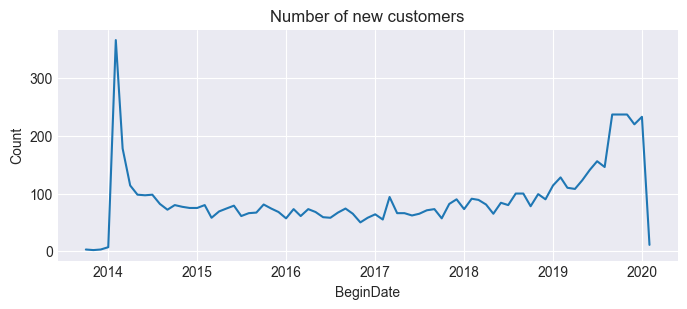

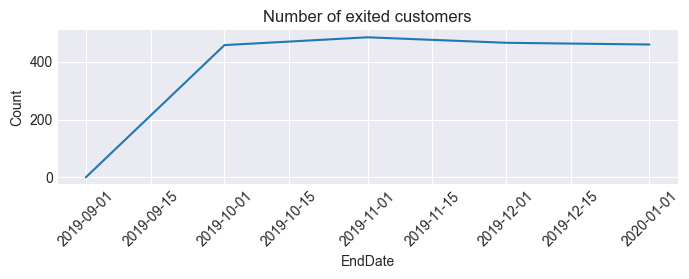

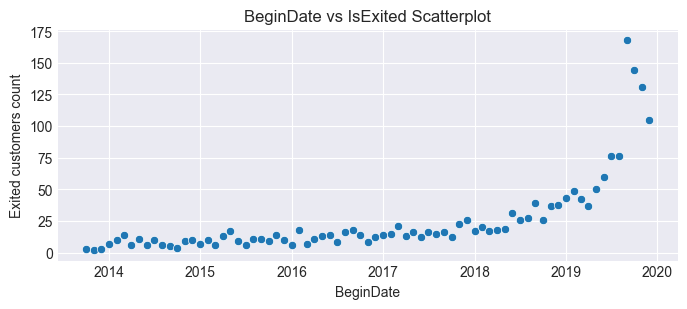

In [32]:
plt.figure(figsize=(8, 3))
sns.lineplot(df.groupby('BeginDate')['BeginDate'].count())
plt.ylabel('Count')
plt.title('Number of new customers')
plt.show()

exited = df[df.EndDate != 'No']
exited.loc[:, 'EndDate'] = pd.to_datetime(exited.EndDate)
exited = exited.groupby('EndDate')['EndDate'].count()
exited.loc['2019-09-01'] = 0

plt.figure(figsize=(8, 2))
sns.lineplot(exited)
plt.ylabel('Count')
plt.title('Number of exited customers')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 3))
sns.scatterplot(df[df.EndDate != 'No'].groupby('BeginDate')['IsExited'].count().reset_index(name='Count'),
                x='BeginDate', y='Count')
plt.ylabel('Exited customers count')
plt.title('BeginDate vs IsExited Scatterplot');

После резкого скачка в 2014 году, который можно связать с полноценным запуском оператора, рост числа пользователей был равномерным до середины 2018 года, где начал ускоряться. Вполне возможно, что в этот период была сделана удачная рекламная кампания, позволившая увеличить темпы роста аудитории. Судя по тому, что первый месяц 2020 года ознаменовался выходом числа новых пользователей на плато, можно предположить, что рекламная кампания несла в себе выгодные условия для новых пользователей, за счет чего клиенты и были привлечены. При этом выгодные условия, вероятно, давались лишь на определенный период, чем можно объяснить увеличение оттока пользователей в конце 2019 - начале 2020 года. 

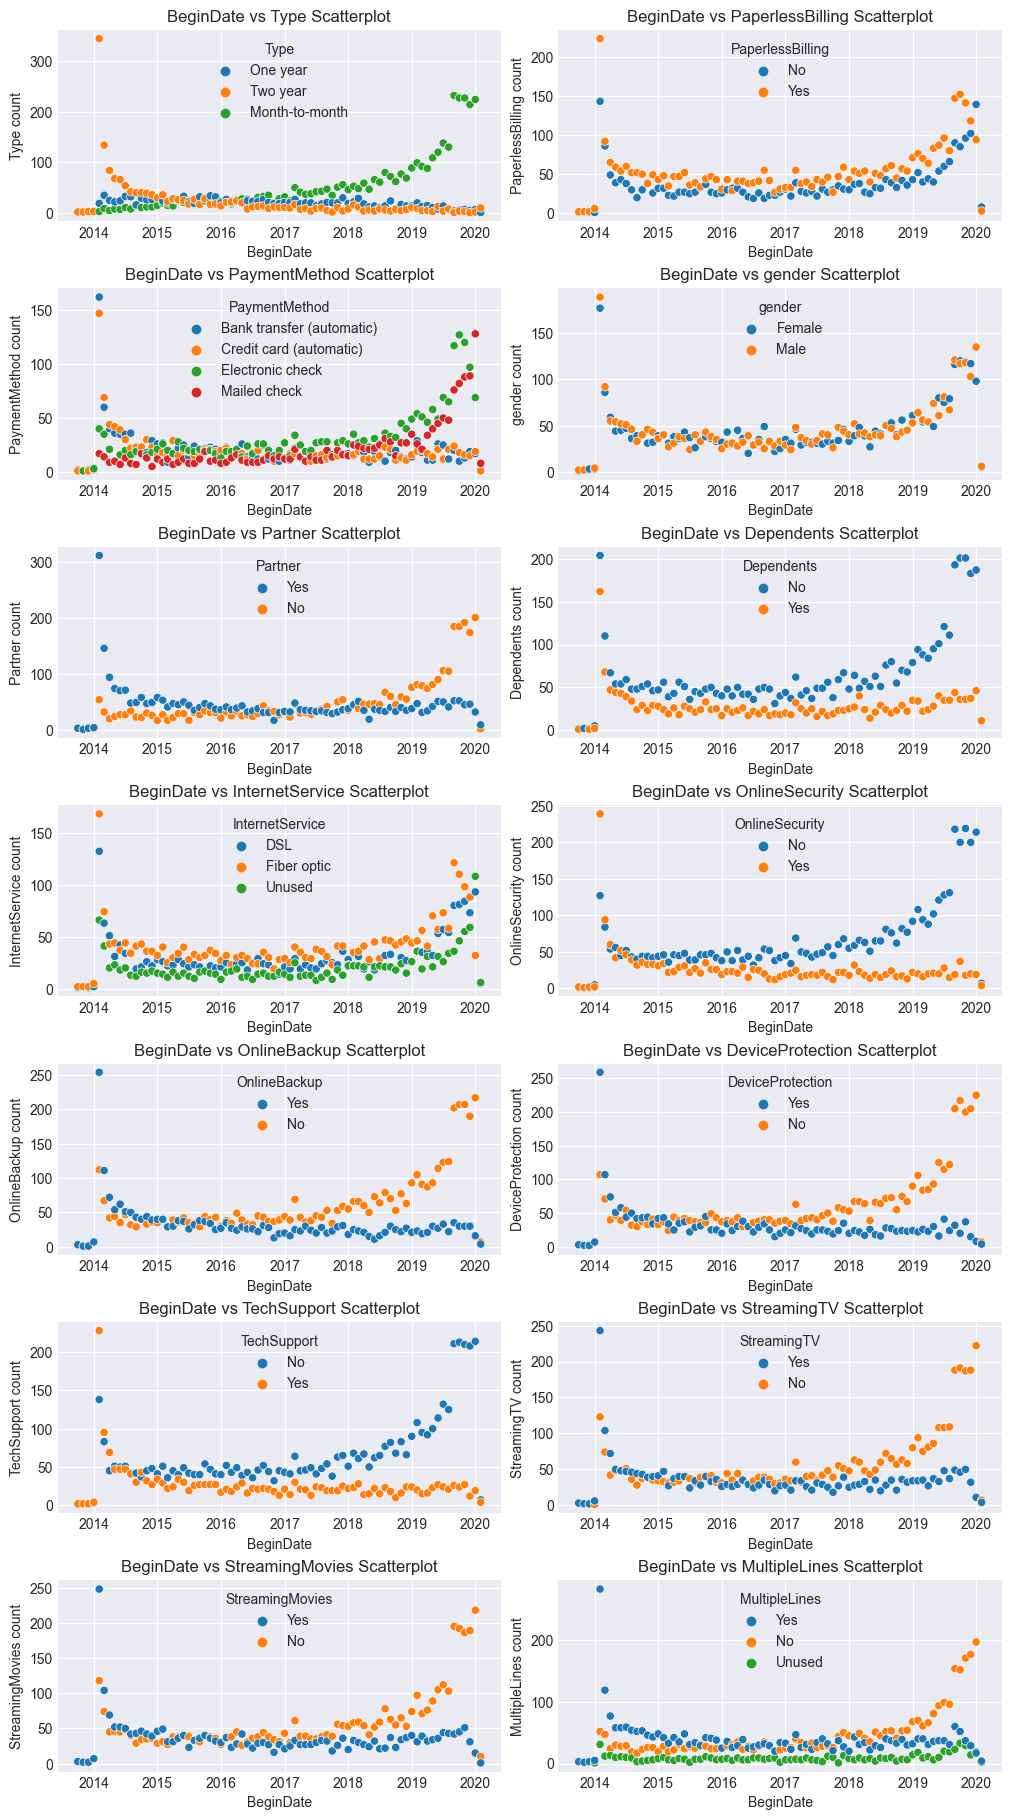

In [33]:
begindate_vs_cats(df, exceptions=['customerID', 'EndDate'])

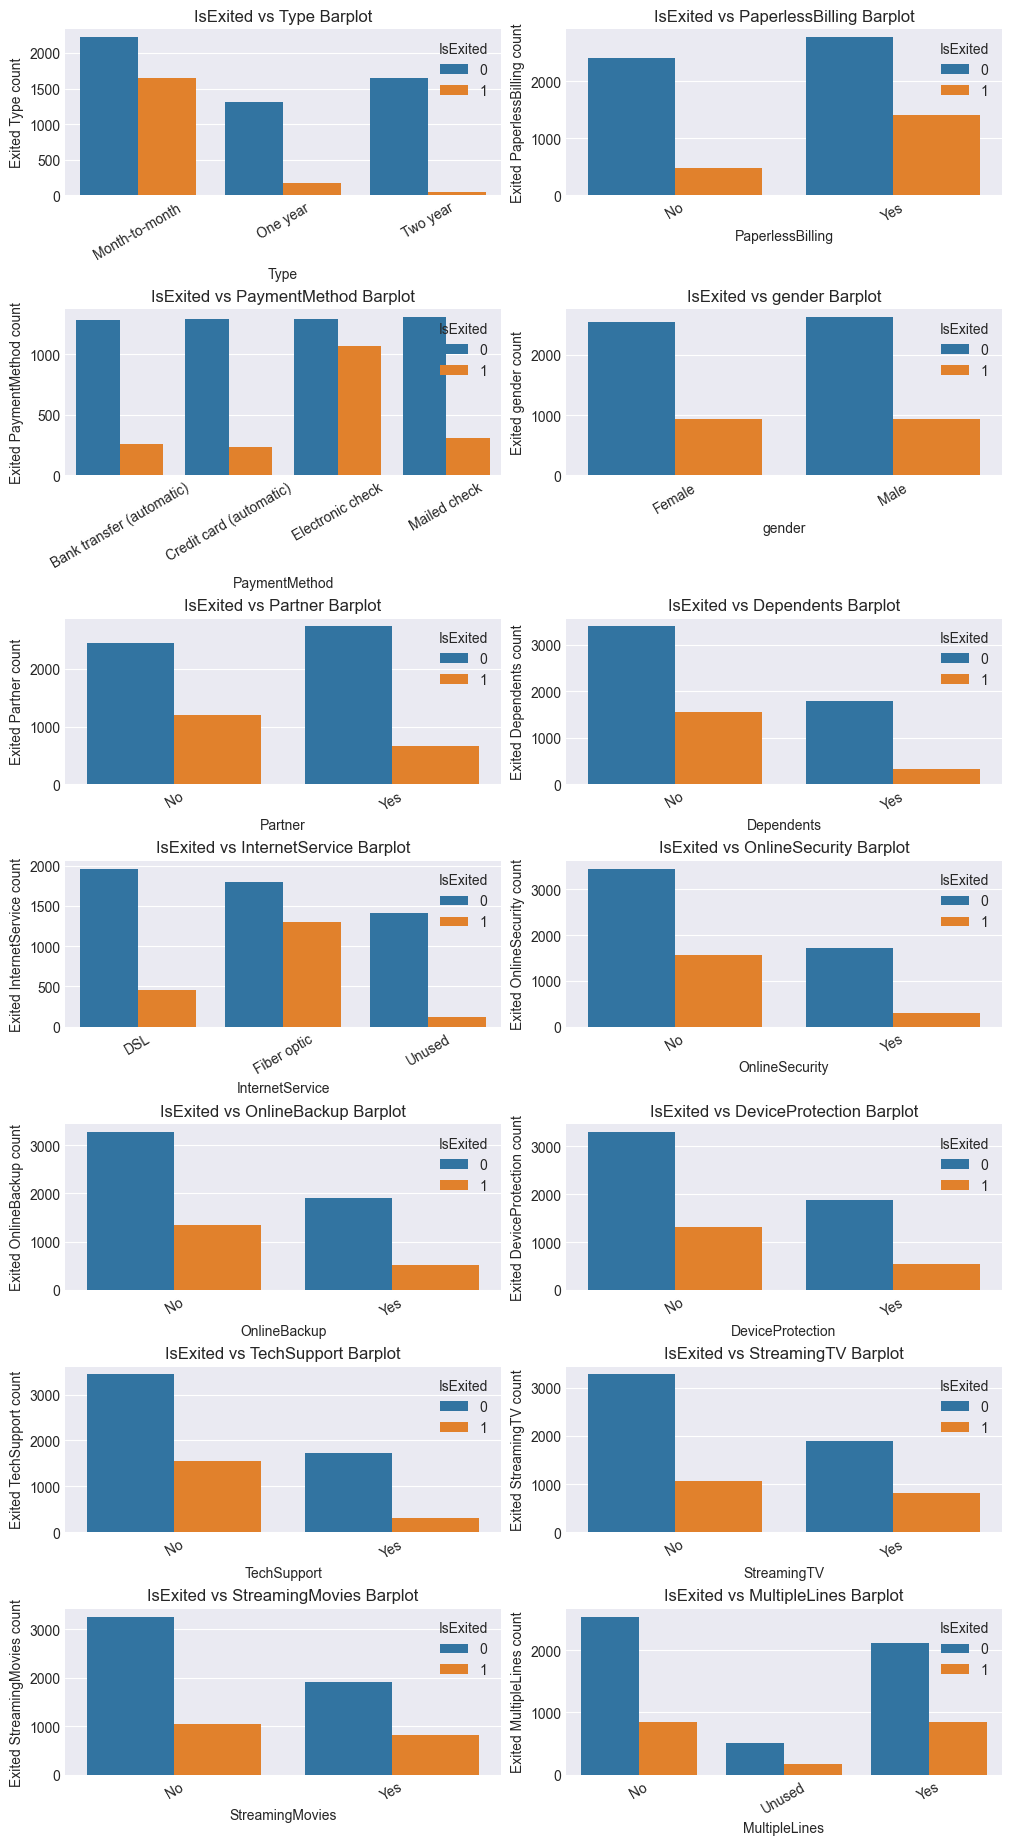

In [34]:
dead_vs_cats(df, exceptions=['customerID', 'EndDate'])

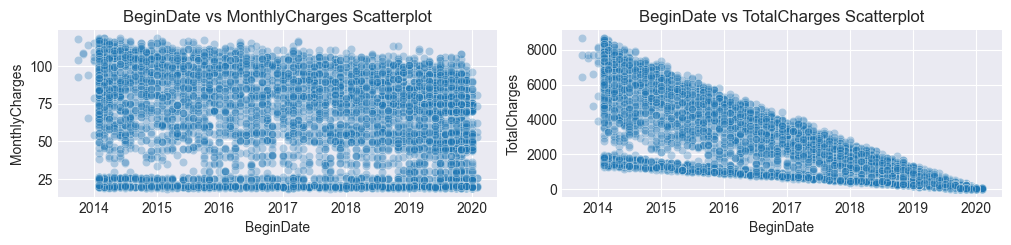

In [35]:
begindate_vs_nums(df, exceptions=['SeniorCitizen', 'IsExited'])

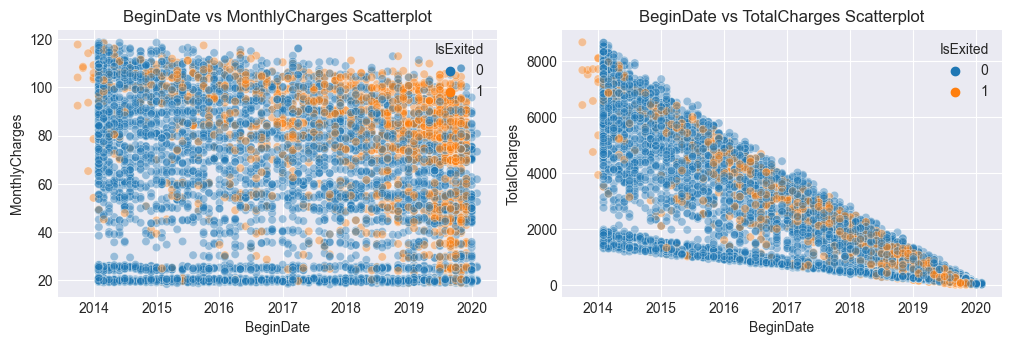

In [36]:
dead_vs_nums(df, exceptions=['SeniorCitizen', 'IsExited'])

Сформируем портрет уходящего клиента: 
- Оплата производится ежемесячно, по безналу;
- Способ оплаты - электронный чек;
- Зачастую не имеет супруга(и);
- Иждивенцев нет;
- Тип подключения интернета - оптоволокно;
- Дополнительными услугами, кроме стриминговых сервисов, не пользуется;
- Пользователь пришел к нам после 2019 года.

Согласно отмеченным выше параметрам выходит, что уходящий клиент это, скорее всего, молодой человек без семьи, технически подкованный(ая) (т.е не пользуется услугами защиты данных, технической поддержки и другими, поскольку может самостоятельно решить возникающие трудности), ожидающий(ая) высокого качества оказания услуг (на это указывает предпочтение оптоволокна), не готовый(ая) к заключение долгосрочного договора. Важную роль играет год начала пользования услугами. 


### Создание признаков и формирование обущающего датасета

In [37]:
df_new = df.copy()

In [38]:
## Создаем отдельный столбец чтобы отметить тех, кто не пользуется телефоном вообще
df_new['UsingPhone'] = 'Yes'
df_new.loc[df.MultipleLines == 'Unused', 'UsingPhone'] = 'No'

## Возвращаем признаку MultipleLines бинарность
df_new.loc[df.MultipleLines == 'Unused', 'MultipleLines'] = 'No'

In [39]:
## Выделяем месяца начала пользования услугами
df_new['BeginMonth'] = pd.DatetimeIndex(df_new['BeginDate']).month

In [40]:
## Создаем столбец с продолжительностью оказания услуг в годах
df_new['ContractDurationYears'] = 0
df_new.loc[df_new.EndDate != 'No', 'ContractDurationYears'] = pd.DatetimeIndex(df_new.loc[df_new.EndDate != 'No', 'EndDate']).year - pd.DatetimeIndex(df_new.loc[df_new.EndDate != 'No', 'BeginDate']).year
df_new.loc[df_new.EndDate == 'No', 'ContractDurationYears'] = 2020 - pd.DatetimeIndex(df_new.loc[df_new.EndDate == 'No', 'BeginDate']).year

In [41]:
## Удаляем лишние столбцы
df_new = df_new.drop(columns=['gender']) 

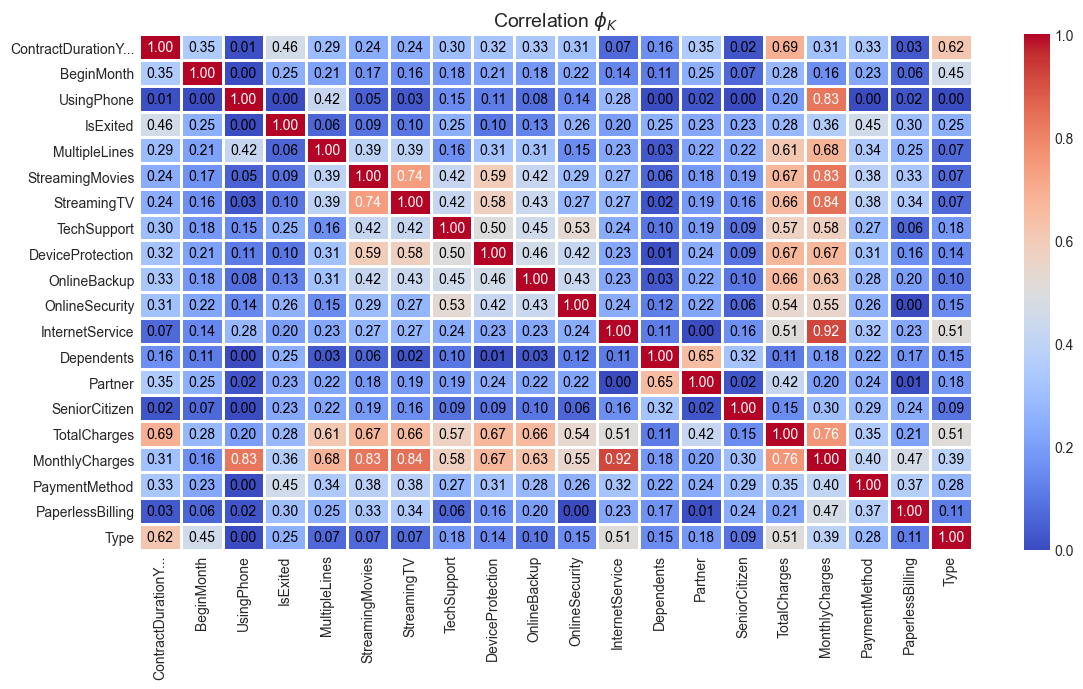

In [42]:
## Correlation matrix

corr_matrix(df_new.drop(columns=['customerID', 'EndDate', 'BeginDate']), ['MonthlyCharges', 'TotalCharges'])

Согласно полученной матрице корреляций, утечка целевого признака не обнаружена. Однако видна сильная корреляция между следующими признаками:
- Размер ежемесячного платежа естественным образом значительно коррелирует с количеством предоставляемых услуг;
- Аналогична ситуация между общей суммой платежей и ежемесячным платежом/годом начала оказания услуг; 
- Между стриминговым телевидением и кино также видна сильная корреляция;
- Годом начала и продолжительностью оказания услуг. 

По причине наличия мультиколлинеарности используемые модели должны содержать в себе возможность применения регуляризации.

Финальный вид датасета, из которого будут отобраны признаки для обучения: 

In [43]:
df_new.sample(5, random_state=RANDOM_STATE)

customerID  BeginDate              EndDate            Type   
1470  6979-TNDEU 2019-06-01                   No  Month-to-month  \
160   8992-VONJD 2019-01-01                   No  Month-to-month   
5843  1480-IVEVR 2017-03-01                   No        One year   
1194  8967-SZQAS 2018-12-01                   No  Month-to-month   
1028  8436-BJUMM 2017-11-01  2020-01-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges   
1470               No               Mailed check           19.20  \
160               Yes           Electronic check           56.00   
5843              Yes  Bank transfer (automatic)           81.60   
1194               No           Electronic check           50.45   
1028              Yes           Electronic check           83.75   

      TotalCharges  SeniorCitizen Partner Dependents InternetService   
1470    156.850006              0      No         No          Unused  \
160     764.549988              0      No        Yes             DSL   
5843   2815.250000              1     Yes         No     Fiber optic   
1194    765.450012              0      No         No             DSL   
1028   2070.600098              0     Yes        Yes     Fiber optic   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV   
1470             No           No               No          No          No  \
160             Yes          Yes               No          No          No   
5843             No           No              Yes          No          No   
1194             No          Yes               No          No          No   
1028             No           No               No          No         Yes   

     StreamingMovies MultipleLines  IsExited UsingPhone  BeginMonth   
1470              No            No         0        Yes           6  \
160               No            No         0        Yes           1   
5843              No           Yes         0        Yes           3   
1194              No            No         0        Yes          12   
1028              No           Yes         1        Yes          11   

      ContractDurationYears  
1470                      1  
160                       1  
5843                      3  
1194                      2  
1028                      3

### Вывод по разделу

В рамках разведочного анализа данных были объединены таблицы, сформирован столбец таргета, оптимизированы типы данных и удалены пропуски. Произведено графическое исследование данных, позволившее установить временные зависимости, связанные с датой начала пользования услугами, а также сформировать портрет уходящего клиента. 

## Построение модели

### Формирование выборок

In [44]:
X = df_new.drop(columns=['BeginDate', 'EndDate', 'customerID', 'IsExited'])
y = df_new.IsExited

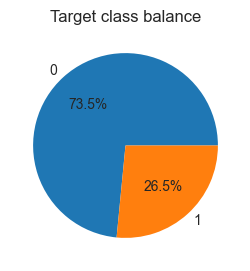

In [45]:
plt.figure(figsize=(3, 3))
plt.title('Target class balance')
plt.pie(y.value_counts(), labels=[0, 1], autopct='%1.1f%%');

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

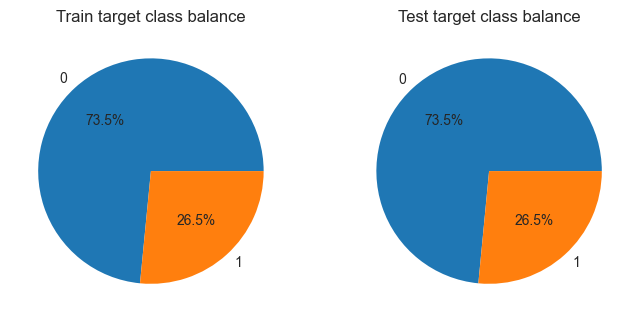

In [47]:
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.title('Train target class balance')
plt.pie(y_train.value_counts(), labels=[0, 1], autopct='%1.1f%%')

fig.add_subplot(1, 2, 2)
plt.title('Test target class balance')
plt.pie(y_test.value_counts(), labels=[0, 1], autopct='%1.1f%%');

Баланс между классами в выборках сохранен. Для обработки дисбаланса классов воспользуемся встроенными методами, где это позволяет сделать модель. 

In [48]:
print(X_train.shape)
X_train.sample(5, random_state=RANDOM_STATE)

(5282, 19)


Type PaperlessBilling              PaymentMethod   
5168  Month-to-month              Yes           Electronic check  \
6384        One year               No               Mailed check   
3150  Month-to-month              Yes               Mailed check   
1716  Month-to-month              Yes    Credit card (automatic)   
1293        Two year              Yes  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges  SeniorCitizen Partner Dependents   
5168           80.80    713.099976              0      No         No  \
6384           20.10    184.399994              0     Yes         No   
3150           25.65    440.200012              0      No         No   
1716           54.75    438.049988              0      No         No   
1293          111.20   7530.799805              0     Yes        Yes   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport   
5168     Fiber optic             No           No               No          No  \
6384          Unused             No           No               No          No   
3150             DSL             No           No               No          No   
1716             DSL             No           No               No          No   
1293     Fiber optic             No          Yes              Yes         Yes   

     StreamingTV StreamingMovies MultipleLines UsingPhone  BeginMonth   
5168          No             Yes            No        Yes           1  \
6384          No              No            No        Yes           4   
3150          No              No            No         No           9   
1716          No             Yes            No        Yes           6   
1293         Yes             Yes           Yes        Yes           7   

      ContractDurationYears  
5168                      0  
6384                      1  
3150                      2  
1716                      1  
1293                      6

### Формирование пайплайнов

In [49]:
NUM, CAT = feature_type(X_train)

In [50]:
col_ohe_transformer = ColumnTransformer(
    [('cat', OneHotEncoder(), CAT),
     ('std', StandardScaler(), NUM)],
    remainder='passthrough'
)

In [51]:
col_oe_transformer = ColumnTransformer(
    [('cat', OrdinalEncoder(), CAT),
     ('std', StandardScaler(), NUM)],
    remainder='passthrough'
)

In [52]:
dummy_pipe = Pipeline(
    [('cat', col_ohe_transformer),
     ('dummy', DummyClassifier())]
)

In [53]:
lregres_pipe = Pipeline(
    [('ohe_std', col_ohe_transformer),
     ('lregres', LogisticRegression())]
)

In [54]:
rforest_pipe = Pipeline(
    [('oe_std', col_oe_transformer),
     ('rforest', RandomForestClassifier())]
)

In [55]:
lgbm_pipe = Pipeline(
    [('oe_std', col_oe_transformer),
     ('lgbm', LGBMClassifier())]
)

In [56]:
cboost_pipe = Pipeline(
    [('oe_std', col_oe_transformer),
     ('cboost', CatBoostClassifier())]
)

### Определение гипер-параметров

In [57]:
lregres_params = {
    'lregres__solver':['liblinear'],
    'lregres__penalty':['l2'],
    'lregres__C':[0.1, 0.5, 1, 3],
    'lregres__class_weight':['balanced'],
    'lregres__random_state':[RANDOM_STATE]
}

In [58]:
rforest_params = {
    'rforest__n_estimators':[500],
    'rforest__max_depth':[10, 12],
    'rforest__random_state':[RANDOM_STATE],
    'rforest__class_weight':['balanced'],
    'rforest__min_samples_split':[2, 3], 
    'rforest__min_samples_leaf':[1, 2] 
}

In [59]:
lgbm_params = {
    'lgbm__learning_rate':[1e-2],
    'lgbm__n_estimators':[1500, 2000],
    'lgbm__reg_alpha':[0, 0.1, 0.2],
    'lgbm__reg_lambda':[0, 0.1, 0.2],
    'lgbm__class_weight':['balanced'],
    'lgbm__random_state':[RANDOM_STATE]
}

In [60]:
cboost_params = {
    'cboost__depth':[6, 8, 10], 
    'cboost__random_strength':[2],
    'cboost__learning_rate':[1e-3],
    'cboost__verbose':[False],
    'cboost__random_seed':[RANDOM_STATE]
}

### Обучение моделей

In [61]:
search_names = ['lregres_search', 'rforest_search', 'lgbm_search', 'cboost_search']
search_pipes = [lregres_pipe, rforest_pipe, lgbm_pipe, cboost_pipe]
search_params = [lregres_params, rforest_params, lgbm_params, cboost_params]

In [62]:
models = {}
search_score = []
for (i, pipe), params in zip(enumerate(search_pipes), search_params):
    search = GridSearchCV(
        pipe,
        params,
        cv=5,
        scoring='roc_auc',
        error_score='raise',
        verbose=3
    )

    search.fit(X_train, y_train)

    print('\n'*2)
    for _ in range(5):
        print('='*79)
    print(f'{search_names[i]} best score')
    print(search.best_score_)
    for _ in range(5):
        print('='*79)
    print('\n'*2)
    
    models[search_names[i]] = search.best_estimator_
    search_score.append(search.best_score_.round(4))


for _ in range(5):
    print('='*79)
print('Cross-Validation Score')
display(pd.DataFrame(search_score, columns=['score'], index=[search_names]).sort_values(by='score', ascending=False))
for _ in range(5):
    print('='*79)
    
    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END lregres__C=0.1, lregres__class_weight=balanced, lregres__penalty=l2, lregres__random_state=7042023, lregres__solver=liblinear;, score=0.919 total time=   0.0s
[CV 2/5] END lregres__C=0.1, lregres__class_weight=balanced, lregres__penalty=l2, lregres__random_state=7042023, lregres__solver=liblinear;, score=0.921 total time=   0.0s
[CV 3/5] END lregres__C=0.1, lregres__class_weight=balanced, lregres__penalty=l2, lregres__random_state=7042023, lregres__solver=liblinear;, score=0.928 total time=   0.0s
[CV 4/5] END lregres__C=0.1, lregres__class_weight=balanced, lregres__penalty=l2, lregres__random_state=7042023, lregres__solver=liblinear;, score=0.914 total time=   0.0s
[CV 5/5] END lregres__C=0.1, lregres__class_weight=balanced, lregres__penalty=l2, lregres__random_state=7042023, lregres__solver=liblinear;, score=0.889 total time=   0.0s
[CV 1/5] END lregres__C=0.5, lregres__class_weight=balanced, lregres__penalty=l2

score
lgbm_search     0.9459
lregres_search  0.9213
rforest_search  0.9158
cboost_search   0.9122

Лучшей оказалась модель LightGMB с следующими параметрами:

In [63]:
models['lgbm_search']['lgbm'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 7042023,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Вывод по разделу

Были обучены 4 классических модели машинного обучения, среди которых лучшей оказалсь модель на основе алгортима LightGBM. Показаны гипер-параметры, при которых результат был достигнут. Разделение на выборки произведено с учетом существующего дисбаланса классов. Во избежания утечки тестовой выборки, часть предобработки данных встроена в пайплайны. 

## Анализ лучшей модели

### Проверка показателей лучшей модели на тестовой выборке

In [64]:
y_pred=models['lgbm_search'].predict(X_test)
print(f'ROC-AUC {roc_auc_score(y_test, y_pred):.4}')
print(f'Accuracy {accuracy_score(y_test, y_pred):.4}')

ROC-AUC 0.8716
Accuracy 0.9069


In [65]:
y_proba = models['lgbm_search'].predict_proba(X_test)

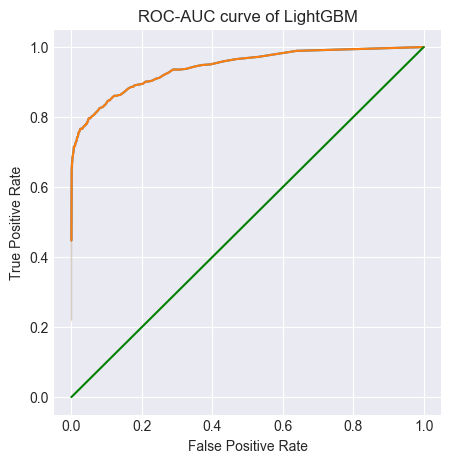

In [66]:
# Calculates 100 coordinates of the ROC Curve
tpr, fpr = get_n_roc_coordinates(y_test, y_proba, n=100)
# Plots the ROC curve
plot_roc_curve(tpr, fpr, scatter=False, md_name='LightGBM')

Модель преодолела установленный порог метрики ROC-AUC

### Интерпретация результатов

In [67]:
fi = pd.DataFrame(data = models['lgbm_search'][1].feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

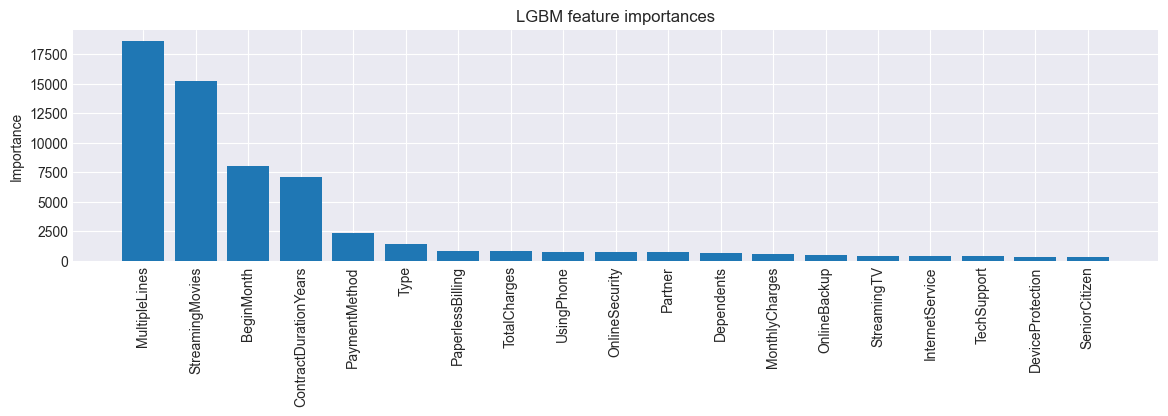

In [68]:
plt.figure(figsize=(14, 3))
plt.bar(x=fi.index, height=fi.importance)
plt.xticks(rotation=90)
plt.title('LGBM feature importances')
plt.ylabel('Importance');


Видно, что ключевую роль в определении уходящего клиента играют два признака, связанные с используемыми услугами: сервисом стримингового кинотеатра и мультилинией. При этом ранее была построена матрица, где указанные признаки имели крайне слабую корреляцию с целевым признаков. Это говорит о более сложной структуре связи признаков.

### Проверка константной моделью

Константная модель (т.е модель, которая всегда предсказывает один ответ) помогает понять, насколько далеко мы продвинулись в качестве предсказания от, собственно, константного предсказания, в нашем случае на основе частотности. Таким образом, если модель всегда будет предсказывать что клиент не уйдет, мы получим ROC-AUC 0.5 и точность 0.7348, что значительно хуже показателей основной выбранной модели. 

In [69]:
dummy_pipe.fit(X_train, y_train);

ROC-AUC 0.5
Accuracy 0.7348


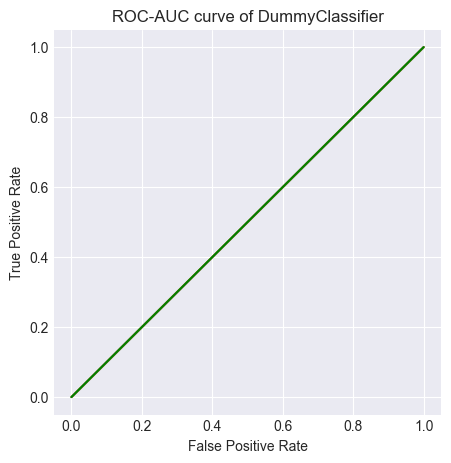

In [70]:
dummy_preds=dummy_pipe.predict(X_test)
print(f'ROC-AUC {roc_auc_score(y_test, dummy_preds):.4}')
print(f'Accuracy {accuracy_score(y_test, dummy_preds):.4}')
dummy_proba = dummy_pipe.predict_proba(X_test)
# Calculates 100 coordinates of the ROC Curve
tpr, fpr = get_n_roc_coordinates(y_test, dummy_proba, n=100)
# Plots the ROC curve
plot_roc_curve(tpr, fpr, scatter=False, md_name='DummyClassifier')

### Вывод по разделу

Полученная модель успешно преодолела границу целевой метрики. Результаты модели заметно превосходят константную модель. Выявлено, что наибольший вклад в формирование предсказания модели вносят признаки **MultipleLines** и **StreamingMovies**.

## Отчет

### Аннотация

Отток клиентов является крупной проблемой для любой компании. Привлечение новых клиентов обходится намного дороже, чем удержание уже имеющихся. Поэтому сокращение оттока клиентов становится одним из ключевых направлений бизнеса. Для этого нужно следить за показателями, вовремя выявлять и устранять тревожные признаки. Неудачные новшества в продукте, потеря актуальности, низкое качество обслуживания - причин для оттока может быть много. Однако, даже при наличии больших объемов данных разобраться в ситуации может бывает крайне трудно. В этой ситуации на помощь приходят модели машинного обучения, которые способны самостоятельно находить закономерности в данных, благодаря чему позволяют быстро и точно определять клиентов, которых компания потенциально может потерять. 

### Введение

Оператор связи "Ниединогоразрыва.ком" хочет построить модель оттока клиентов и научиться предсказывать, какие клиенты могут уйти от компании. Для этого были собраны персональные данные о некоторых клиентах, информация об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: стационарную телефонную связь и интернет. Доступны также другие услуги, такие как интернет-безопасность, выделенная линия технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

Необходимо построить модель, способную на основе имеющихся данных определить уйдет клиент или нет.
Целью исследования является достижение значения основной метрики AUC-ROC не менее 0.85. В качестве дополнительной метрики используется Accuracy.

Таким образом, можно выделить следующие основные шаги: 
- Проанализировать данные, понять их содержимое, подготовить его к передачи моделям машинного обучения;
- Обучение моделей и определение лучшей;
- Оценка и интерпретация лучшей модели.

### Ход исследования

Для достижения цели исследования, были проведены следующие этапы:  

**First look** - быстрый обзор данных;  
**EDA** - исследование и визуализация данных для лучшего понимания;  
**Feature engineering** - создание новых признаков и отбор наиболее значимых признаков;  
**Формирование пайплайнов** - подготовка пайплайнов автоматической обработки данных и их передачи моделям;  
**Обучение моделей** - обучение различных моделей машинного обучения;  
**Проверка на тестовой выборке** - оценка качества моделей на тестовой выборке;  
**Проверка константной моделью** - проверка качества моделей в сравнении с простой константной моделью;  
**Заключение** - подведение итогов исследования.  

### Обзор исследуемых данных

Компанией было предоставлено четыре таблицы: **contract**, **personal**, **internet** и **phone**. 

В таблице **contract** размером (7043, 8) содержится информация о договоре с клиентом, который скрывается под обозначением customerID. Присутствуют следующие столбцы:

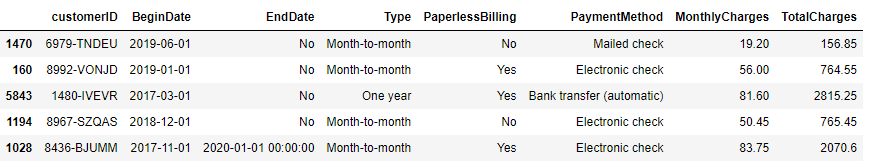

- **BeginDate** - дата начала пользования услугами;
- **EndDate** - дата окончания пользования услугами;
- **Type** - тип оплаты: ежемесячный, годовой и т.ж;
- **PaperlessBilling** - подключен ли безналичный расчет;
- **PaymentMethod** - способ оплаты;
- **MonthlyCharges** - ежемесячные траты на услуги;
- **TotalCharges** - всего потрачено денег на услуги.  

Существует ошибка в типе данных: столбец **TotalCharges** имеет тип object, хотя должен быть float. При этом топовое значение, подсчитанное методом `.describe()`, показывает пустую строку. Вероятно, в данном столбце имеются пустые значения неопределенной длины. Поквартильное распределение значений в столбце **MonthlyCharges** довольно равномерно, не имеет явно выбивающихся значений, из чего можно сделать предварительный вывод, что выбросов в данном столбце нет. Также в данной таблице находится столбец, в котором зашит наш таргет: если в столбце **EndDate** напротив id клиента стоит дата, значит он ушел. 


В таблице **personal** размером (7043, 5) содержится информация о клиенте, который скрывается под обозначением customerID. Присутствуют следующие столбцы:

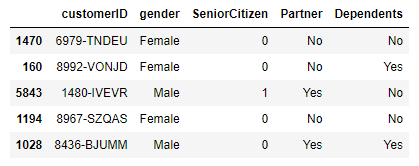


- **gender** - пол клиента;
- **SeniorCitizen** - наличие пенсионного статуса по возрасту;
- **Partner** - наличие супруга(и);
- **Dependents** - наличие иждивенцев.

Типы данных соответствуют смыслу столбцов. Число строк совпадает с таблицей **contact**. Столбцы **customerID** в таблицах **contact** и **personal** равнозначны. 



В таблице **internet** размером (5517, 8) содержится информация об условиях, на которых подключены услуги интернета у клиентов, скрывающихся под обозначением customerID. Присутствуют следующие столбцы:

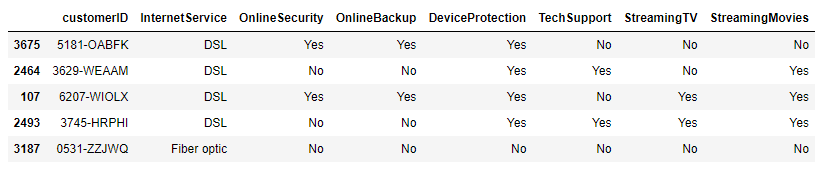

- **InternetService** - тип подключения (DSL или Fiber Optic);
- **OnlineSecurity** - статус услуги блокироки небезопасных сайтов;
- **OnlineBackup** - статус услуги облачного хранилища;
- **DeviceProtection** - статус услуги антивируса;
- **TechSupport** - статус услуги выделенной линии тех.поддержки;
- **StreamingTV** - статус услуги стримингового телевидения;
- **StreamingMovies** - статус услуги каталога фильмов. 

Типы данных соответствуют смыслу столбцов. Число строк отлично от таблицы **contact**. Это значает, что не у всех клиентов подключены услуги, связанные с интернетом. 



- В таблице **phone** размером (6361, 2) содержится информация об условиях, на которых подключены услуги телефонии у клиентов, скрывающихся под обозначением customerID. Таблица содержит следующие столбцы:

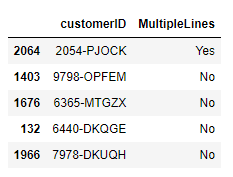

- **MultipleLines** - наличие возможности ведения параллельных линий во время звонка. 

Типы данных соответствуют смыслу столбцов. 

Число строк отлично от таблицы **contact**. Это значает, что не у всех клиентов подключены услуги, связанные с телефонией. 

### Разведочных анализ данных


**Первичные преобразования**

Перед началом анализа были произведены следующие манипуляции с данными: 

1. Для получения общего датасета таблицы **contract**, **personal**, **internet** и **phone** были объединены по столбцу **customerID**. Проверка методом `.duplicated()` не обнаружила в столбце **customerID** дубликатов, что говорит о том что сшивка проведена корректно.  


2. Для формирования столбца таргета использован столбец **EndDate**. Он содержит 5 вариантов значений: `'No'` означает, что клиент все еще с нами, а прочие значения говорят о том, что клиент ушел. Довольно странно, что клиенты уходили только в последние 3 месяца 2019 года и 1 января 2020, ведь, как правило, срок оплаты договора привязывается к дате его заключения. Причем в каждую дату ушло приблизительно равное число клиентов. В любом случае, необходимо перобразовать столбец в булев массив. В нашем случае `'No'` соответствует 0, а прочие значения 1. Таким образом создан столбец **IsExited**, который и является таргетом.  


3. Ранее замечено, что толбец **TotalCharges** имеет тип object, хотя состоит из числовых значений типа float. Причиной этому служат строки, содержащие двойной пробел в качестве значения. Все даты в столбце **BeginDate** для указанных значений **TotalCharges** совпадают: 2020-02-01. Поскольку известно, что данные актуальны на 2020-01-01, воспользуемся предположением, что пропуск в столбце **TotalCharges** является отсутствием актуализированной информацией и заполним столбец значением помесячной оплаты, которая нам известна.


4. Заполнение пропусков. Обычно заполнение пропусков производится после анализа данных, но в данном случае справедливо будет сначала избавиться от пропусков, поскольку их природа вполне понятна и имеет смысл учесть значения при анализе. Статистика пропусков следующая: 
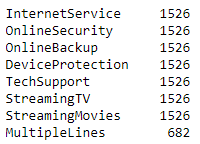

    Существующие пропуски были порождены при соединении таблиц, поэтому `NaN` соотвествует `'No'` для всех столбцов с пропусками, за исключением **OnlineService** и **MultipleLines**. Для выделенных столбцов необходимо отдельное значение, соответствующее отсутствию услуги телефонии или интернета у клиента. Заполним пропуски строкой `'Unused'`.

**Графическое исследование данных** 

Посмотрим, как выглядят зависимости, связанные с днем начала пользования услугами и днем ухода пользователя.  

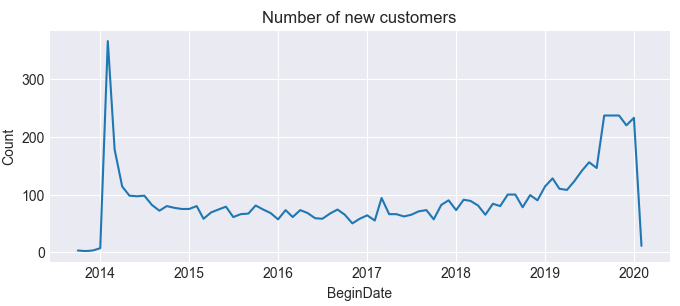

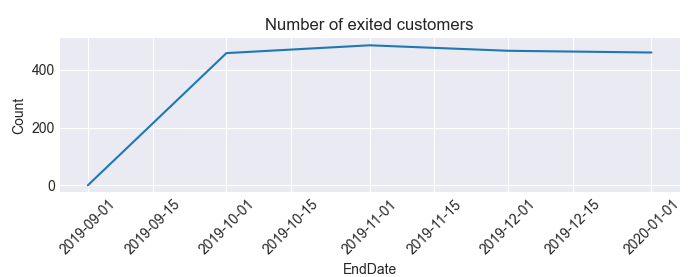

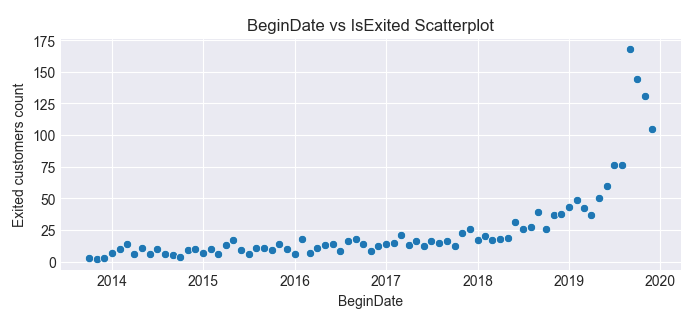

После резкого скачка в 2014 году, который можно связать с полноценным запуском оператора, рост числа пользователей был равномерным до середины 2018 года, где начал ускоряться. Вполне возможно, что в этот период была сделана удачная рекламная кампания, позволившая увеличить темпы роста аудитории. Или оператор начал предоставлять свои услуги в рамках нового жилого микрорайона, где обладал положением единственной компании, предоставлявшей подобные услуги. В любом случае, видно разделение клиентов на два типа: тех, кто пришел после 2018-2019 года, и тех, кто пришел раньше. 

Продолжим исследование и посмотрим, как зависят параметры клиента от даты начала пользования услугами. 

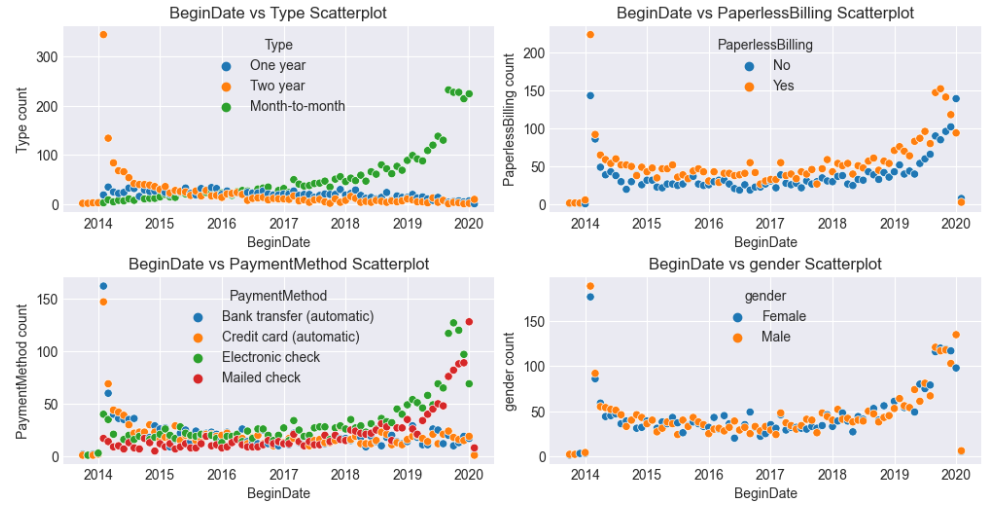

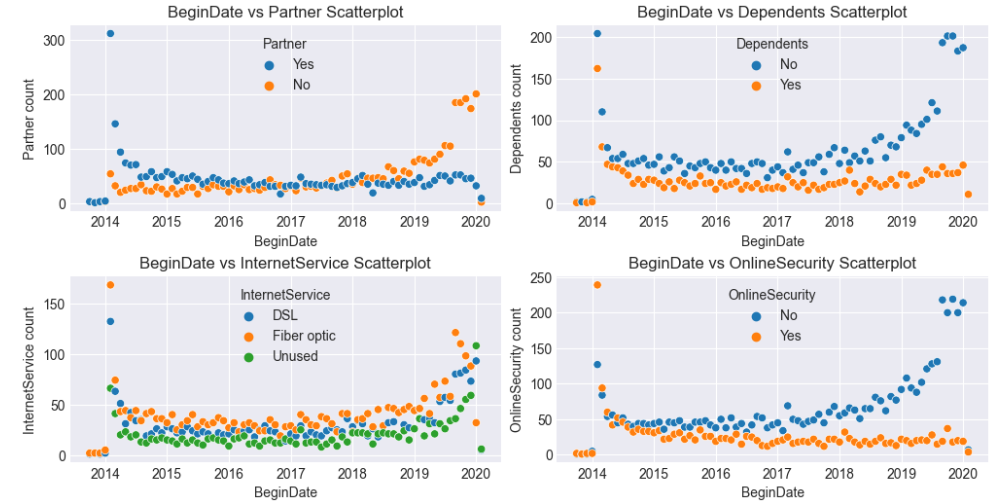

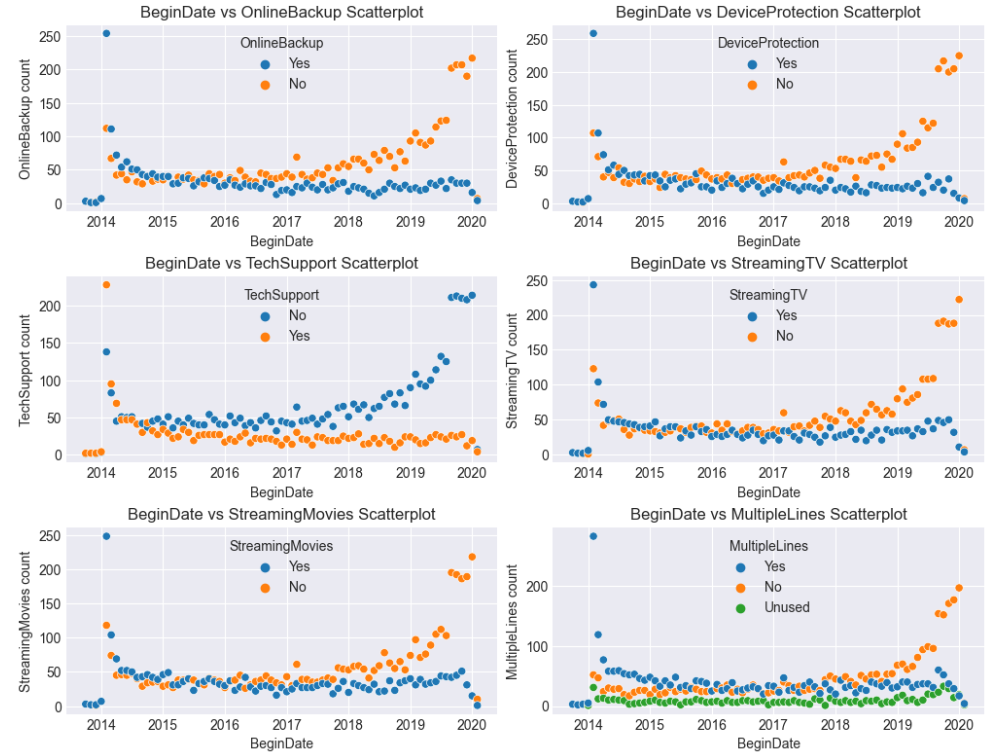

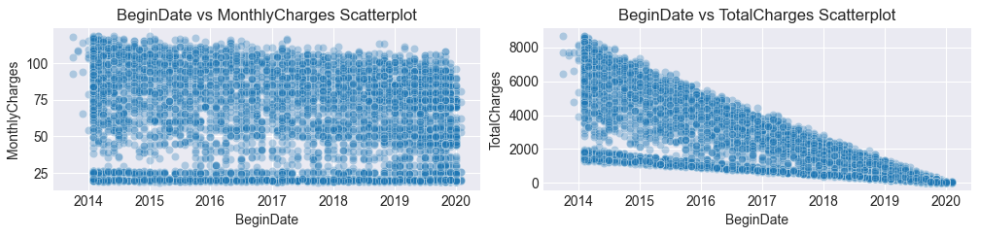

Проанализируем полученные зависимости и попробуем определить, как менялись предпочтения пользователей с течением времени:
- После середины 2016 года ежемесячная модель оплаты стала более популярна, чем ежегодичная или двухгодичная, хотя в 2014-ом наиболее популярной была последняя; 
- Предпочтения относительно безналичной оплаты не поменялись. Оплата наличными все еще популярна;
- Вместе с ростом популярности ежемесячной оплаты, выросла популярность неавтоматических способов оплаты;
- Услугами одинаково часто пользуются как мужчины, так и женщины;
- Заметна тенденция, что пользователи, пришедшие после 2018 года, реже находятся в браке и имеют иждивенцев;
- Предпочтения в типе интернет-подключения и его наличия меняется не сильно;
- Пользователи, пришедшие после 2018 года, не пользуются дополнительными услугами онлайн-защиты, онлайн-бэкапа, защиты устройств, дополнительной технической поддержки, стриминговых сервисов и мульти-линии.

При этом стоимость услуг с течением времени оставалась примерно одной и той же.


Теперь посмотрим на графики, характеризующие уходящих пользователей: 

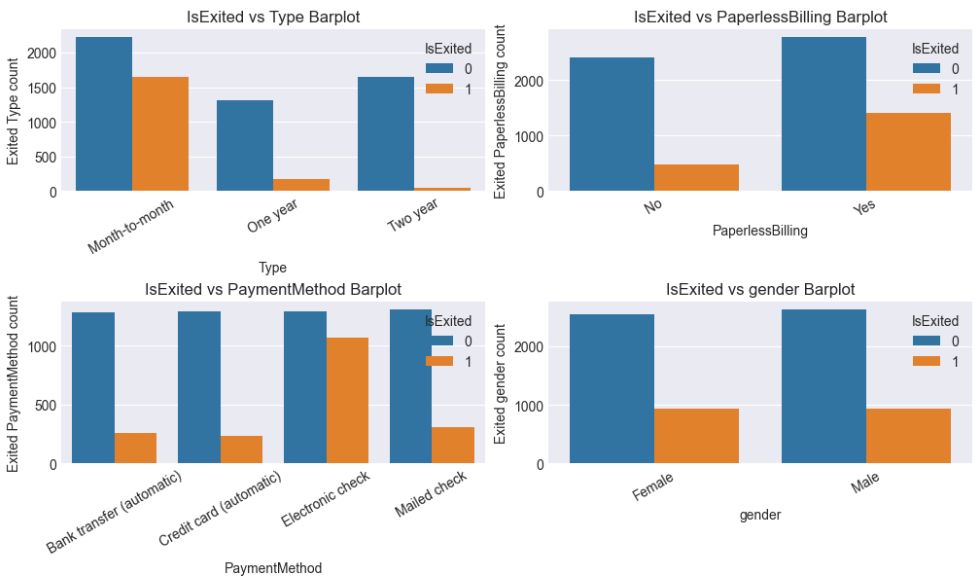

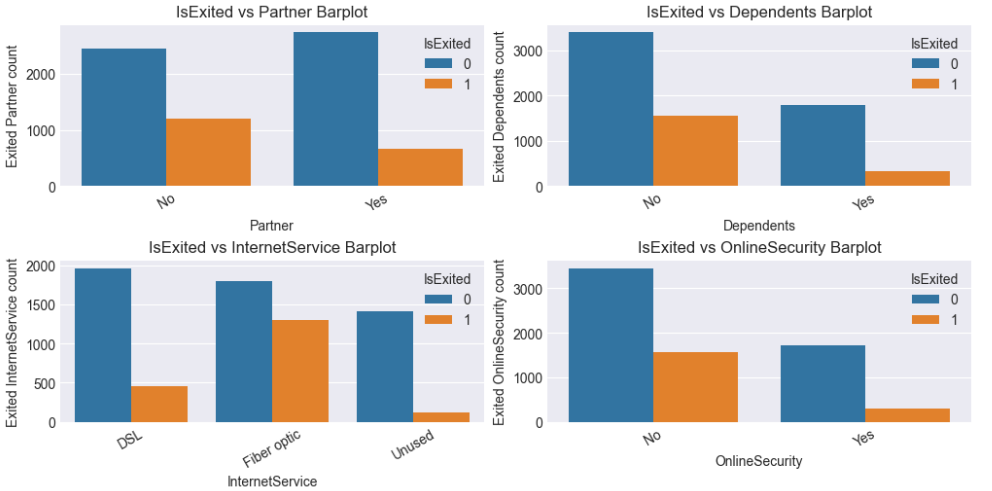

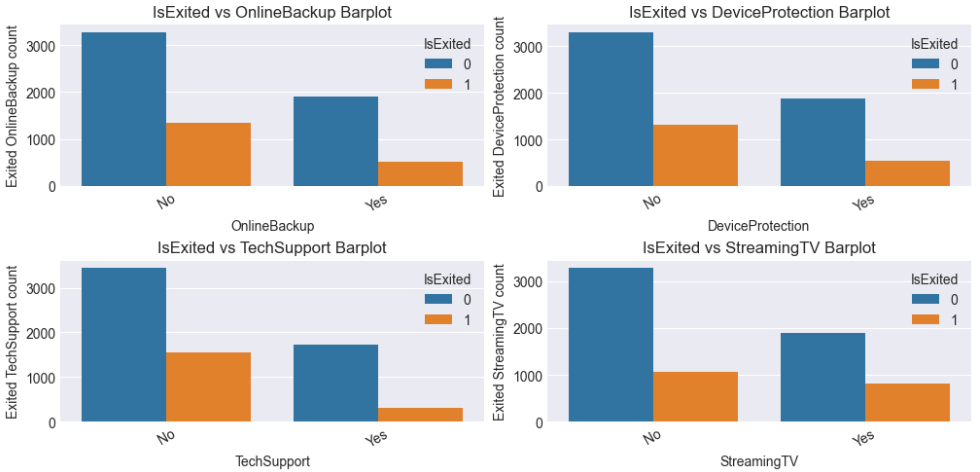

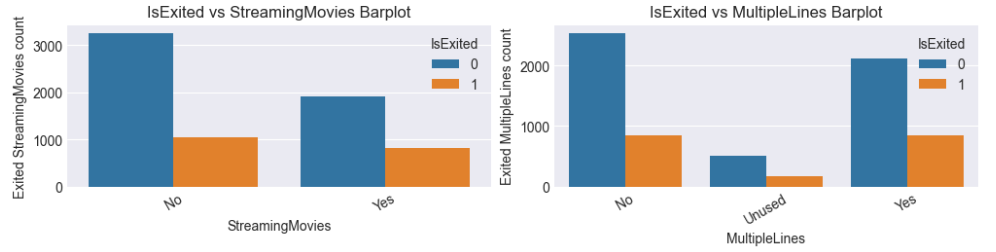

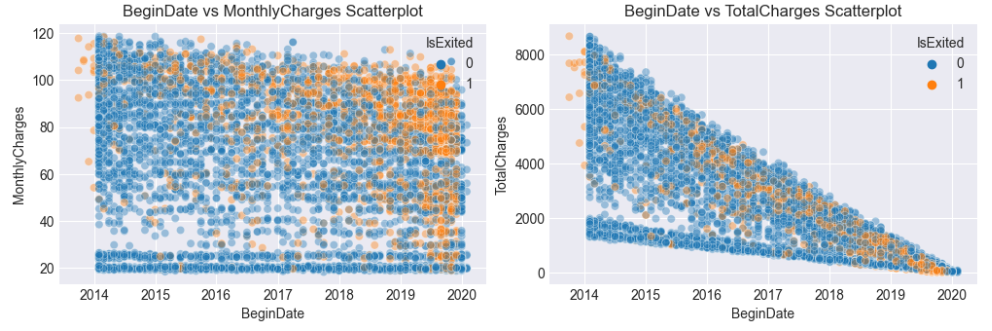


Сформируем портрет уходящего клиента: 
- Оплата производится ежемесячно, по безналу;
- Способ оплаты - электронный чек;
- Зачастую не имеет супруга(и);
- Иждивенцев нет;
- Тип подключения интернета - оптоволокно;
- Дополнительными услугами, кроме стриминговых сервисов, не пользуется;
- Пользователь пришел к нам после 2019 года;
- Как правило, стоимость услуг уходящего клиента выше среднего.

Согласно отмеченным выше параметрам выходит, что уходящий клиент это, скорее всего, молодой человек без семьи, технически подкованный(ая) (т.е не пользуется услугами защиты данных, технической поддержки и другими, поскольку может самостоятельно решить возникающие трудности), ожидающий(ая) высокого качества оказания услуг (на это указывает предпочтения относительно оптоволокна), не готовый(ая) к заключение долгосрочного договора. Важную роль играет год начала пользования услугами. 


### Создание признаков и формирование обущающего датасета

Создадим копию текущего датафрейма и произведем следующие изменения в его структуре:

1. При помощи столбца **MultipleLines** создадим новый бинарный столбец **UsingPhone**. Если в столбце **MultipleLines** оказалось значение 'Unused', то в столбце **UsingPhone** будет стоять 'No', в остальных случаях 'Yes'. После создания нового столбца вернем столбцу **MultipleLines** бинарность, заменив все 'Unused' на 'No';

2. Разложим столбец **BeginYear** на два отдельных столбца: год и месяц. Это важный признак, поскольку чаще уходят именно относительно новые клиенты;

3. Создадим столбец с продолжительностью оказания услуг в годах как разницу столбцами **EndDate** и **BeginDate**. Если пользователь от нас не ушел, вместо **EndDate** используем значение '2020-02-01';

4. Пол пользователя никак не влияет на поведение клиента, поэтому данный признак нам не пригодится и его можно удалить. 

Посмотрим на матрицу корреляций полученного датафрейма без учета столбцов **BeginYear**, **EndDate** и **customerID**.

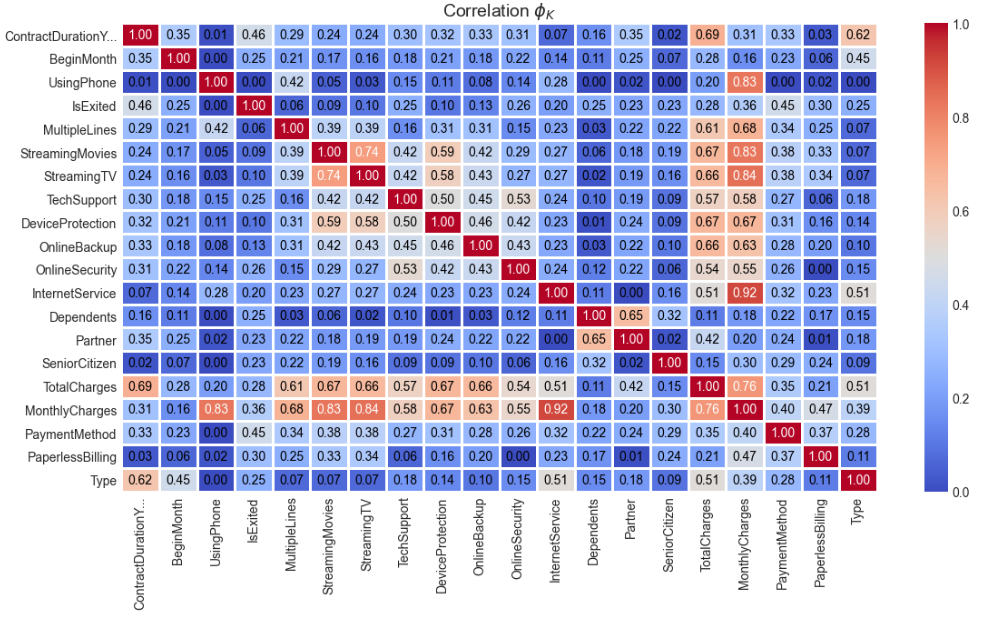

Согласно полученной матрице корреляций, утечка целевого признака не обнаружена. Однако видна сильная корреляция между следующими признаками:
- Размер ежемесячного платежа естественным образом значительно коррелирует с количеством предоставляемых услуг;
- Аналогична ситуация между общей суммой платежей и ежемесячным платежом/годом начала оказания услуг; 
- Между стриминговым телевидением и кино также видна сильная корреляция;
- Годом начала и продолжительностью оказания услуг. 

По причине наличия мультиколлинеарности используемые модели должны содержать в себе возможность применения регуляризации.

Финальный датафрейм, на основе которого будут создаваться обучающая и тестовая выборки, содержит следующие признаки: 

**customerID,  
BeginDate,  
EndDate,  
Type,  
PaperlessBilling,  
PaymentMethod,  
MonthlyCharges,  
TotalCharges,  
SeniorCitizen,  
Partner,  
Dependents,  
InternetService,  
OnlineSecurity,  
OnlineBackup,  
DeviceProtection,  
TechSupport,  
StreamingTV,  
StreamingMovies,  
MultipleLines,  
IsExited,  
UsingPhone,   
BeginMonth,  
ContractDurationYears**  

В используемом датасете наблюдается дисбаланс классов:

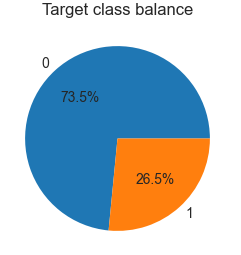

Поэтому, чтобы сохранить данный дисбаланс и в тренировочной, и в обучающей выборке, в функции `train_test_split` использовался параметр `stratify`, которому был передан столбец таргета. Для обработки дисбаланса классов во время обучения используются встроенные методы, где это позволяет сделать модель.

### Формирование пайплайнов

При формировании пайплайнов созданы объекты ColumnTransformer, в которые добавлены Ohe-Hot- и Ordinal-энккодеры для категориальных, а также StandardScaler для количественных признаков. Далее указанные трансформеры встроены в объекты Pipeline, соответствующие используемым моделям. Пример полученного пайплайна:

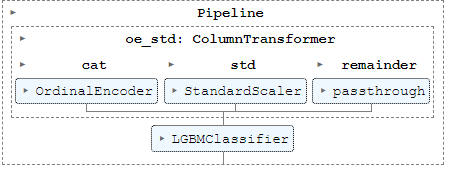

### Выбор моделей 

В текущем исследовании применяются 4 классических модели машинного обучения: 1 простая линейная регрессия, 1 простой ансамбль и 2 градиентных бустинга. Применение глубокого обучения в случае табличных данных нецелесообразно. К тому же, результат работы нейронных сетей гораздо сложнее интерпретировать, поэтому нейронные сети в данной работе не используются. 

Самой простой, базовой моделью является модель логистической регрессии. По сути, данная модель делит подаваемые данные на две части при помощи некоторой наиболее оптимальной по мнению модели гиперплоскости. Данная модель отличается высокой скоростью обучения и предсказания.

В качестве более сложной модели используется лес случайных деревьев, то есть ансамбль решающих деревьев. Данная модель представляет собой набор деревьев, каждое из которых обучено на случайно отобранных подвыборках. Ответ такой модели формируется как самый популярный ответ среди всех деревьев. Благодаря сложной нелинейной структуре, данная модель способна показывать гораздо лучшие результаты на тех данных, которые трудно пространственно разделить одной гипер-плоскостью. 

Также применены два градиентных бустинга: LightGBM и Catboost. Суть градиентного бустинга заключается в последовательном уменьшении ошибки посредством итеративного обучения простой модели на основе ошибок предшественника и последующем сложении предсказаний. Предложенные алгоритмы главным образом различаются в способе построения дерева: если LightGBM строит несбалансированное дерево, растущее лишь в одном направлении, каждый раз разделяясь по наиболее оптимальному листу, то Catboost делает это более жадно, создавая листы на каждом уровне дерева. Это сказывается на скорости алгоритмов: LightGBM может быть заметно быстрее Catboost. 

### Обучение моделей

При обучении моделей использовались наборы гипер-параметров, среди которых выбирался наиболее оптимальный при помощи случайного поиска с кросс-валидацией. Стоит отметить, что в случае логистической регрессии, леса случайных деревьев и LightGBM доступен параметр class_weigth='balanced', позволяющий автоматически подстроить веса каждого класса. Кросс-валидационные результаты моделей по метрике ROC-AUC: 
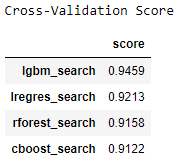

Лучше оказалась модель LightGBM с следующими гипер-параметрами: 

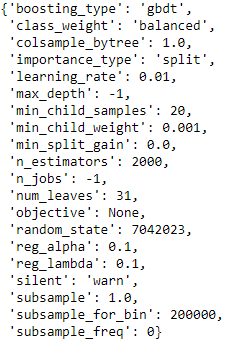

### Проверка лучшей модели на тестовой выборке

В результате построения предсказаний на тестовой выборке модель LightGBM показала значения метрики ROC-AUC 0.8716 и Accuracy 0.9069. Кривая ROC-AUC на тестовой выборке: 
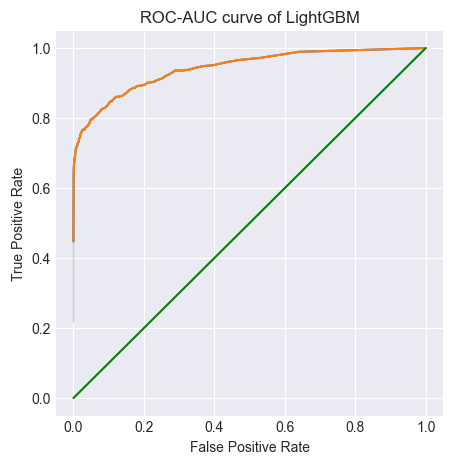

Построим матрицу ошибок ответов нашей модели:

                                                        1225 69  
                                                         95 372
                                                         
Значения метрик Precision и Recall 0.8435 и 0.7966 соответственно. 

Таким образом, помимо очевидно "хороших" ответов (1225 True Positives и 372 True Negatives), модель дает 69 False Positives и 95 False Negatives. Это говорит о том, что текущая модель чаще не видит уходящего клиента, чем видит его там, где его нет - "мягкая модель". С одной стороны, из-за этого увеличивается шанс пропустить целевого пользователя, с другой, модель не создает давления в тех местах, где его не требуется - условно, скидка не будет предложена тем пользователи, которые и так не собирались уходить. 

### Интерпретация результатов 

График важности признаков:

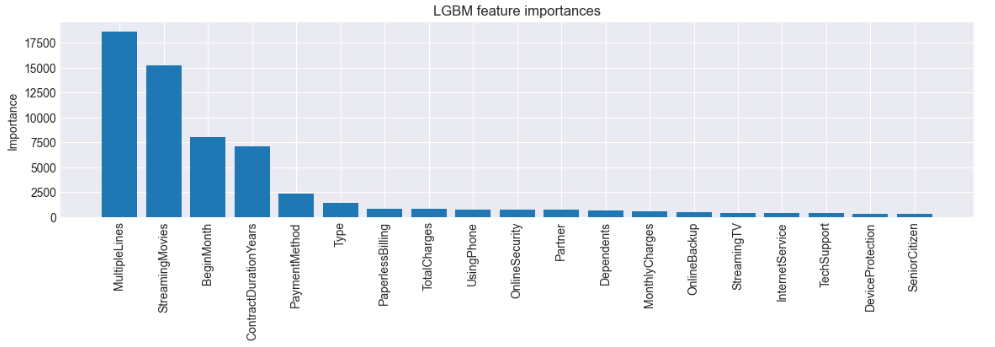

Видно, что ключевую роль в определении уходящего клиента играют два признака, связанные с используемыми услугами: сервисом стримингового кинотеатра и мультилинией. При этом ранее была построена матрица корреляций, где указанные признаки имели крайне слабую корреляцию с целевым признаков. Это говорит о более сложной структуре связи признаков. Признаки, лежащие за признаком **Type**, выглядят как совсем неиспользуемые, однако это не так. Удаление всех малоиспользуемых признаков приводит к ухудшению метрик на 5-10%. 

### Проверка константной моделью

Константная модель (т.е модель, которая всегда предсказывает один ответ) помогает понять, насколько далеко мы продвинулись в качестве предсказания от, собственно, константного предсказания, в нашем случае на основе частотности. Таким образом, если модель всегда будет предсказывать что клиент не уйдет, мы получим ROC-AUC 0.5 и точность 0.7348, что значительно хуже показателей основной выбранной модели. 

### Заключение

В ходе проведенного исследования была рассмотрена возможность создания модели оттока для оператора связи "Ниединогоразрыва.ком" на основе имеющейся информации о клиентах компании. Все пункты предложенного плана работ были успешно реализованы. 

При помощи разведочного анализа данных были произведены чистка датасета и формирование новых признаков, а также удаление заведомо ненужных. Замечено, что применение даты начала пользования услугами в качестве признака создает утечку целевого признака, в связи с чем его нельзя применить несмотря на его большую значимость.

Сформирована обучающая и тестовая выборки. Обучено 4 модели, лучшая из которых построена на основе алгоритма LightGBM, отличающегося сравнительно высокой скоростью работы при высоком качестве предсказаний. Показатели метрик ROC-AUC и Accuracy лучшей модели на тестовой выборке составляют 0.8716 и 0.9069 соответственно, что значительно превосходит показатели константной модели и выполняет поставленные требования. 